In [2]:
import pandas as pd

# === 1. Load Dataset ===
file_path = "TSLA_2015_2025_Histogram.csv"
df = pd.read_csv(file_path)

# === 2. Membersihkan nilai numerik ===
# Hilangkan koma dan ubah menjadi float
cols_to_clean = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in cols_to_clean:
    df[col] = df[col].str.replace(',', '').astype(float)

# === 3. Konversi kolom tanggal dan urutkan ===
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.sort_values('date')

# === 4. Buat kolom target klasifikasi: 'Price_Up' ===
# Price_Up = 1 jika harga penutupan naik dari hari sebelumnya
df['Price_Up'] = df['Close'].diff().apply(lambda x: 1 if x > 0 else 0)

# === 5. Hapus baris pertama (karena NaN akibat diff()) ===
df = df.dropna().reset_index(drop=True)

# === 6. Simpan dataset hasil preprocessing jika diperlukan ===
df.to_csv("TSLA_Preprocessed.csv", index=False)

# Tampilkan 5 baris hasil akhir
print(df[['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price_Up']].head())

        date          Open          High           Low         Close  \
0 2015-01-02  1.485800e+08  1.488333e+09  1.421733e+09  1.462067e+09   
1 2015-01-05  1.430333e+09  1.443333e+08  1.381067e+09  1.400600e+09   
2 2015-01-06  1.400400e+09  1.428000e+09  1.361400e+09  1.408533e+09   
3 2015-01-07  1.422333e+09  1.431867e+09  1.398533e+09  1.406333e+09   
4 2015-01-08  1.418733e+09  1.425333e+09  1.400067e+09  1.404133e+08   

       Volume  Price_Up  
0  71466000.0         0  
1  80527500.0         0  
2  93928500.0         1  
3  44526000.0         0  
4  51637500.0         0  


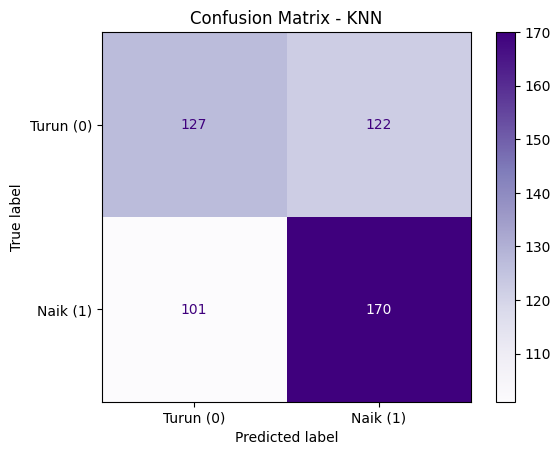

=== Classification Report ===
              precision    recall  f1-score   support

       Turun       0.56      0.51      0.53       249
        Naik       0.58      0.63      0.60       271

    accuracy                           0.57       520
   macro avg       0.57      0.57      0.57       520
weighted avg       0.57      0.57      0.57       520



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt

# === 1. Load Dataset ===
df = pd.read_csv("TSLA_Preprocessed.csv")

# === 2. Fitur dan Target ===
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Price_Up']

# === 3. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 4. Normalisasi Fitur (Wajib untuk KNN) ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Inisialisasi dan Latih Model KNN ===
knn = KNeighborsClassifier(n_neighbors=5)  # Anda bisa coba n_neighbors=3,7,9, dll.
knn.fit(X_train_scaled, y_train)

# === 6. Prediksi ===
y_pred = knn.predict(X_test_scaled)
y_prob = knn.predict_proba(X_test_scaled)[:, 1]

# === 7. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Turun (0)", "Naik (1)"])
disp.plot(cmap='Purples', values_format='d')
plt.title("Confusion Matrix - KNN")
plt.show()

# === 8. Classification Report ===
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Turun", "Naik"]))

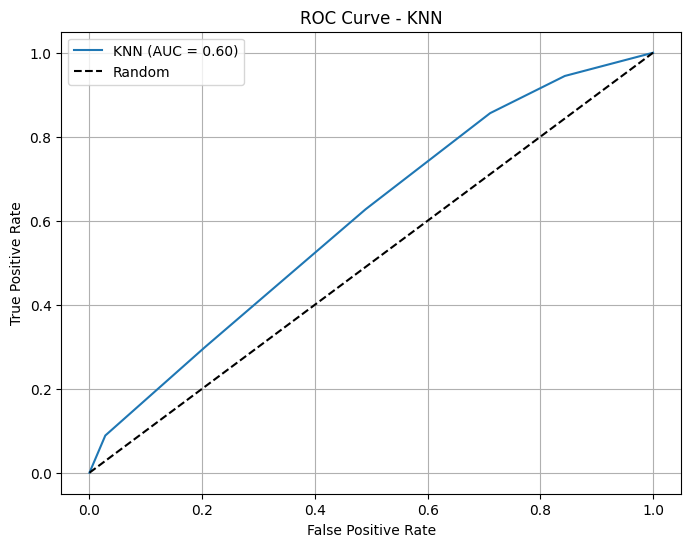

AUC Score: 0.6030


In [2]:
# === 9. ROC Curve dan AUC ===
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"KNN (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN")
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC Score: {auc_score:.4f}")